# Plots boundary conditions

Import packages

In [1]:
import script.pyPLUTO as pp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.image import imread

import numpy as np
import pandas as pd

# some commonly used constants
CONST_mp = 1.67262171e-24  # gr

Settings matplotlib

In [2]:
mpl.rcParams["figure.dpi"] = 150    # about the dpi for a 15 inch 1080p laptop, makes sure the displayed plots are the real size 
#mpl.rcParams["figure.dpi"] = 600

mpl.rcParams["figure.figsize"] = (6, 3.5)
mpl.rcParams["axes.labelsize"] = 12

mpl.rcParams["axes.formatter.limits"] = (-4, 4)

mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=["xkcd:royal blue", "xkcd:vermillion", "xkcd:orange", 
                                                    "xkcd:magenta", "xkcd:lime", "xkcd:yellow", "grey"])

mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["axes.linewidth"] = .5

mpl.rcParams["font.size"] = 12

mpl.rcParams["text.usetex"] = True


#mpl.rcParams["figure.facecolor"] = "#fffbf0"
#mpl.rcParams["axes.facecolor"] = "#fffbf0"
#mpl.rcParams["savefig.facecolor"] = '#fffbf0'

Usefull functions

In [3]:
def get_extent(file, firstline):
    """this functions retrieves the extent of the grid (in code-units) and number of points from the grid.out 
    file in one dimension (starting at firstline)
    
    file: the grid.out file
    firstline: the line in the file to look for the number of points in that dimension"""
    with open(file, "r") as gridfile:
        lines = gridfile.readlines()
        # get the number of points
        NUM_POINTS = int(lines[firstline])

        # get the extent of the x-axis (in code units)
        # the first line of the grid, so minimum coordinate
        line = lines[firstline+1]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_min = float(parts[1])
        # the last line
        line = lines[firstline+NUM_POINTS]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_max = float(parts[2])
    
    return (NUM_POINTS, (d_min, d_max))

Import metadata about the output such as the time corresponding to each files and conversion factors from code units to physical units

In [4]:
# specify the directories where the data is stored and where the output should be stored
DATA_DIR = "data/plume-raw-G3/"
OUT_DIR = "data/images/density/"

# get info about the stored data
file_data = pd.read_csv(DATA_DIR+"dbl.out", sep=" ", names=["index", "t", "dt", "step", "type", "little", "rho",
                                                            "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"])
# delete columns that are not needed
for column in ["index", "type", "little", "rho", "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"]:
    del file_data[column]

# define the conversion factors
UNIT_NUMBER_DENSITY = 1e9
UNIT_DENSITY = UNIT_NUMBER_DENSITY*CONST_mp
UNIT_LENGTH = 1e8 # cm
UNIT_VELOCITY = 1e8 # cm/s

X_POINTS = 0
Y_POINTS = 0
X_EXTENT = (0,0)
Y_EXTENT = (0,0)

# get the extend of the grid
# get the extent of the x-axis (in code units)
X_POINTS, X_EXTENT = get_extent(DATA_DIR+"grid.out", 9)
# get the extent of the y-axis
Y_POINTS, Y_EXTENT = get_extent(DATA_DIR+"grid.out", 10+X_POINTS)

# number of files saved
N = len(file_data["t"])

## Initial condition hole

In [5]:
def velocity(t, T0, v0, a0, a1):
    return v0*np.tanh(t/a0) - v0/2*(np.tanh((t-T0)/a1)+1)

Reading Data file : data/plume-raw-G3/data.0000.dbl


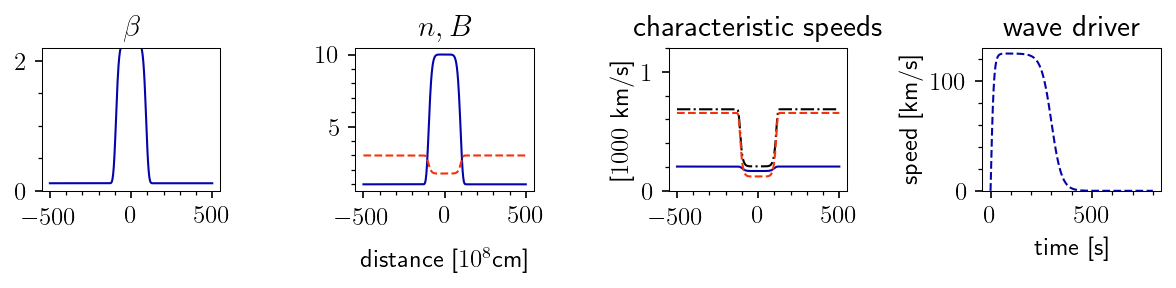

In [6]:
mpl.rcParams["lines.linewidth"] = 1

side = 500
diam = 150
n_out = 1e9
n_in = 1e8
R = np.linspace(-side,side,1000)

# import data
D = pp.pload(0, w_dir=DATA_DIR)
X = np.linspace(X_EXTENT[0], X_EXTENT[1], 1024)
START = int(1/4*X_POINTS)
END = int(3/4*X_POINTS)
SECTION = int(1/2*X_POINTS)

fig, ax = plt.subplots(1,4, figsize=(8,2))

# density and magnetic field
axis = ax[1]
axis.plot(X[START:END], D.rho[SECTION,START:END]*10, linestyle="-")
axis.plot(X[START:END], D.Bx3[SECTION,START:END]*np.sqrt(4*np.pi*UNIT_DENSITY)*UNIT_VELOCITY, 
          linestyle="--")
axis.set_title(r"$n, B$")
axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

# plasma beta
axis = ax[0]
axis.plot(X[START:END], D.prs[SECTION,START:END]/(D.Bx3[SECTION,START:END]**2/2))
axis.set_title(r"$\beta$")
axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.set_ylim(0,2.2)

# speeds
axis = ax[2]
sound = np.sqrt(D.prs/D.rho*5/3)
axis.plot(X[START:END], sound[SECTION,START:END], label=r"$v_s$")
alfven = D.Bx3/np.sqrt(D.rho)
vplus = np.sqrt(sound**2+alfven**2)
axis.plot(X[START:END], vplus[SECTION,START:END], "k-.")
axis.plot(X[START:END], alfven[SECTION,START:END], linestyle="--", label=r"$v_a$")
axis.set_ylabel("[$1000$ km/s]")
axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.set_title("characteristic speeds")
axis.set_ylim(0,1.2)

# wave driver
axis = ax[3]
#axis.plot(T, velocity(T, 600, 50, 20, 60), label="hole")
T1 = np.linspace(0,800,1000)
axis.plot(T1, velocity(T1, 300, 50*5/2, 16, 50), "--", label="plume")
axis.set_title("wave driver")
axis.set_xlabel("time [s]")
axis.set_ylabel("speed [km/s]")
#axis.legend()
axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.set_ylim(0,130)

fig.text(0.38, 0.07, r"distance [$10^8$cm]", ha="center")

plt.tight_layout()
plt.show()

fig.savefig("../verslag/images/sections-initial-condition-plume.pdf")

## Frames density 

In [61]:
## preparation

T = file_data["t"].values
extent_temp = X_EXTENT + Y_EXTENT
extent = [value*UNIT_LENGTH*1e-11 for value in extent_temp]

# region cut out for wave inside of plume
# select region
MIN = 430
MAX = 594
min_coord = (X_EXTENT[0] + (X_EXTENT[1]-X_EXTENT[0])*MIN/1024)/(1000)
max_coord = (X_EXTENT[0] + (X_EXTENT[1]-X_EXTENT[0])*MAX/1024)/(1000)
# pressure inside plume
ex = [value*UNIT_LENGTH*(MAX-MIN)/1023*1e-11 for value in extent_temp]
# circle of characteristic diameter
d = 100/X_EXTENT[1]
THETA = np.linspace(0,2*np.pi,1000)
X_circ = d*np.cos(THETA)
Y_circ = d*np.sin(THETA)

indicies = [86, 96, 106, 123, 137, 155]
D_arr = [pp.pload(i, DATA_DIR) for i in indicies]

Reading Data file : data/plume-raw-G3/data.0086.dbl
Reading Data file : data/plume-raw-G3/data.0096.dbl
Reading Data file : data/plume-raw-G3/data.0106.dbl
Reading Data file : data/plume-raw-G3/data.0123.dbl
Reading Data file : data/plume-raw-G3/data.0137.dbl
Reading Data file : data/plume-raw-G3/data.0155.dbl


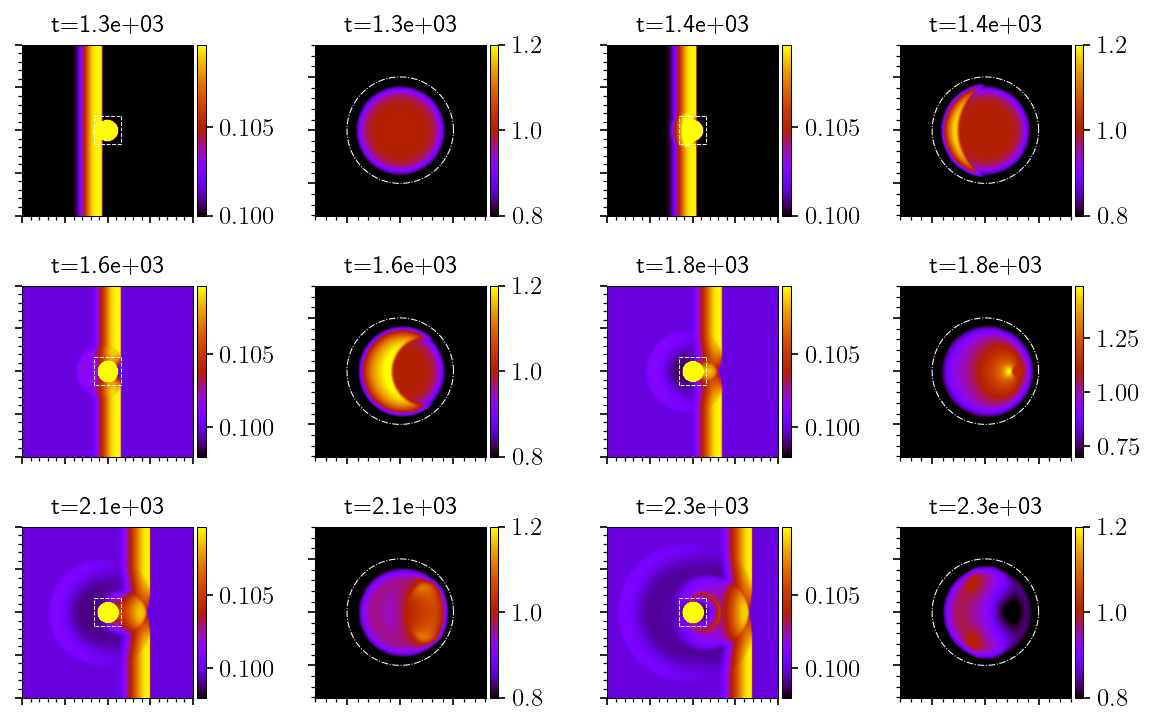

In [63]:
fig, ax = plt.subplots(3,4,figsize=(8,5))

for i in range(6):
    axis_out = ax[i//2][2*(i%2)]
    axis_in = ax[i//2][2*(i%2)+1]
    D = D_arr[i]
    
    n = indicies[i]
    
    ### outside view
     # select cutoffs
    if n < 105:
        vmin=0.1
    else:
        vmin=0.098
    vmax = 0.10965

    # pressure outside plume
    axis = axis_out
    im=axis.imshow(np.transpose(D.rho), vmin=vmin, vmax=vmax, extent=extent, cmap="gnuplot")
    cbar = fig.colorbar(im, ax=axis, fraction=0.0465, pad=0.02)
    #cbar.ax.set_ylabel('Density [code units]', rotation=270, fontsize=12, labelpad=15)
    axis.set_title("t=%.1e"%T[n], fontsize=12)
    # draw box of the inset
    axis.plot([min_coord, min_coord], [min_coord, max_coord], "w--", lw=0.5)
    axis.plot([min_coord, max_coord], [max_coord, max_coord], "w--", lw=0.5)
    axis.plot([max_coord, max_coord], [max_coord, min_coord], "w--", lw=0.5)
    axis.plot([max_coord, min_coord], [min_coord, min_coord], "w--", lw=0.5)
    # draw the circle of characteristic width for the plume/hole
    #axis.plot(X_circ,Y_circ,"-.k",lw=0.5)
    # small ticks
    axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    axis.set_xticklabels([])
    axis.set_yticklabels([])
    
    ### inside view
    # select cutoffs
    if (n < 115) or (n > 135):
        vmin = 0.8
        vmax = 1.2
    else:
        vmin = 0.8 - 1/121*1/10*(n-114)*(136-n)
        vmax = 1.2 + 1/121*3/10*(n-114)*(136-n)

    # pressure inside plume
    axis = axis_in
    im=axis.imshow(np.transpose(D.rho[MIN:MAX,MIN:MAX]), vmin=vmin, vmax=vmax, extent=ex, cmap="gnuplot")
    cbar = fig.colorbar(im, ax=axis, fraction=0.0465, pad=0.02)
    #cbar.ax.set_ylabel('Density [code units]', rotation=270, fontsize=12, labelpad=15)
    #axis.set_title("Density inside plume", fontsize=16)
    axis.plot(X_circ,Y_circ,"-.w",lw=0.5)
    axis.set_title("t=%.1e"%T[n], fontsize=12)
    axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    axis.set_xticklabels([])
    axis.set_yticklabels([])
    
plt.tight_layout()
plt.show()

fig.savefig("../verslag/images/plume-frames.pdf")

## Sections

In [65]:
X = np.linspace(X_EXTENT[0], X_EXTENT[1], X_POINTS)
ref = pp.pload(0, DATA_DIR)
SECTION = int(1/2*X_POINTS)

colors = ["xkcd:royal blue", "xkcd:vermillion", "xkcd:lime", 
          "xkcd:magenta", "xkcd:orange", "grey"]

indicies = [33, 81, 97, 129, 155, 222]
D_arr = [pp.pload(i, DATA_DIR) for i in indicies]

Reading Data file : data/plume-raw-G3/data.0000.dbl
Reading Data file : data/plume-raw-G3/data.0033.dbl
Reading Data file : data/plume-raw-G3/data.0081.dbl
Reading Data file : data/plume-raw-G3/data.0097.dbl
Reading Data file : data/plume-raw-G3/data.0129.dbl
Reading Data file : data/plume-raw-G3/data.0155.dbl
Reading Data file : data/plume-raw-G3/data.0222.dbl


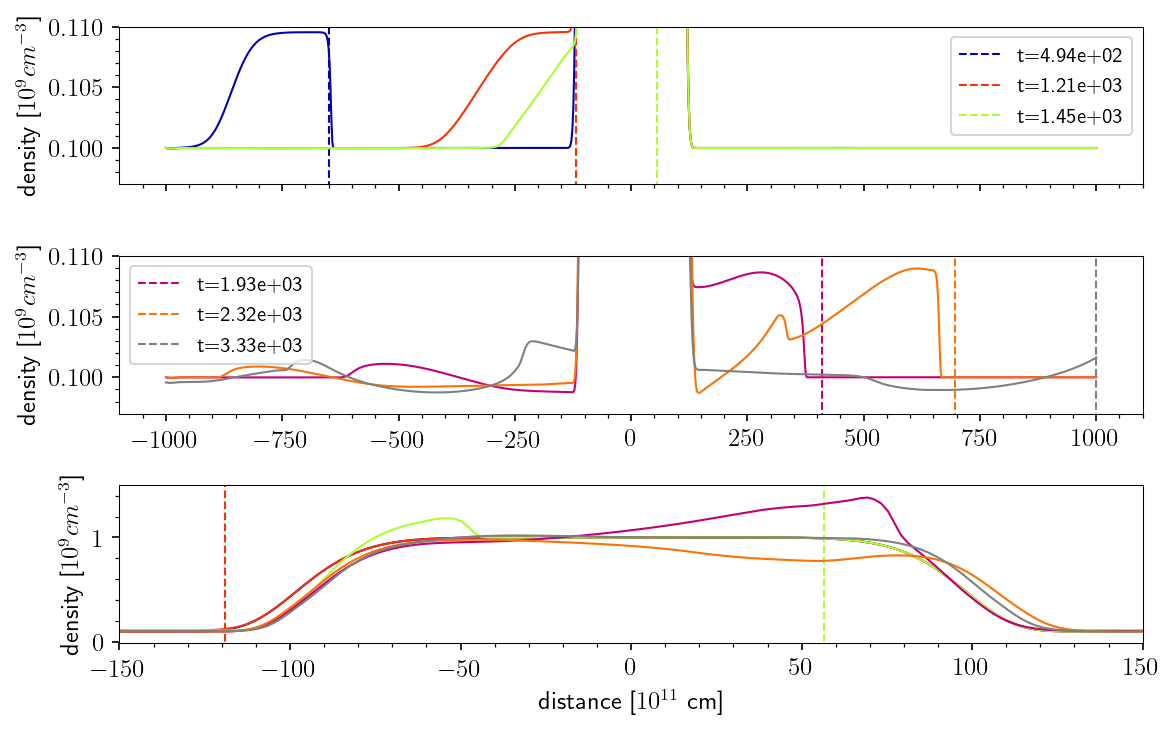

In [66]:
fig, ax = plt.subplots(3,1, figsize=(8,5))

for i in range(6):
    D = D_arr[i]
    color=colors[i]
    
    # find the front of the wave
    large = (D.rho[:,0]/ref.rho[:,0])>1.05 # the large excitations
    indexes = np.where(large == 1)
    try:
        index = indexes[0][-1]
        physical_position = X_EXTENT[0] + (X_EXTENT[1]-X_EXTENT[0])*index/X_POINTS
    except:
        physical_position = X_EXTENT[1]
        
    # outside 1
    if (i<3):
        axis = ax[0]
        axis.plot(X, D.rho[:,SECTION], color=color)
        axis.plot([physical_position, physical_position], [-10,10], '--', color=color, 
                  label="t=%.2e"%T[indicies[i]])

    # outside 2
    if (i>2):
        axis = ax[1]
        axis.plot(X, D.rho[:,SECTION], color=color)
        axis.plot([physical_position, physical_position], [-10,10], '--', color=color,
                 label="t=%.2e"%T[indicies[i]])

    # inside - absolute positions
    axis=ax[2]
    axis.plot(X, D.rho[:,SECTION], color=color)
    axis.plot([physical_position, physical_position], [-10,10], '--', color=color)
    
# lay-out first plot
axis = ax[0]
axis.set_ylim(0.097,0.11)
axis.set_xticklabels([])
axis.set_ylabel(r"density [$10^9 cm^{-3}$]")
axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.legend(loc="upper right", fontsize=10)

# lay-out second plot
axis = ax[1]
axis.set_ylim(0.097,0.11)
#axis.set_xticklabels([])
axis.set_ylabel(r"density [$10^9 cm^{-3}$]")
axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.legend(loc="upper left", fontsize=10)

# lay-out third plot
axis = ax[2]
axis.set_ylim(-0.01,1.5)
axis.set_xlim(-150,150)
axis.set_ylabel(r"density [$10^9 cm^{-3}$]")
axis.set_xlabel(r"distance [$10^{11}$ cm]")
axis.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
axis.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

plt.tight_layout()

fig.savefig("../verslag/images/plume-sections.pdf")

### wave driver and density cuts

cache some snapshots

In [144]:
N = [50, 75, 105, 120, 145, 170]
frames = [pp.pload(n, DATA_DIR) for n in N]
ref = pp.pload(0, DATA_DIR)

Reading Data file : data/plume-raw-G3/data.0050.dbl
Reading Data file : data/plume-raw-G3/data.0075.dbl
Reading Data file : data/plume-raw-G3/data.0106.dbl
Reading Data file : data/plume-raw-G3/data.0120.dbl
Reading Data file : data/plume-raw-G3/data.0145.dbl
Reading Data file : data/plume-raw-G3/data.0170.dbl
Reading Data file : data/plume-raw-G3/data.0000.dbl


277
-458.984375
417
-185.546875
592
156.25
671
310.546875
812
585.9375
953
861.328125


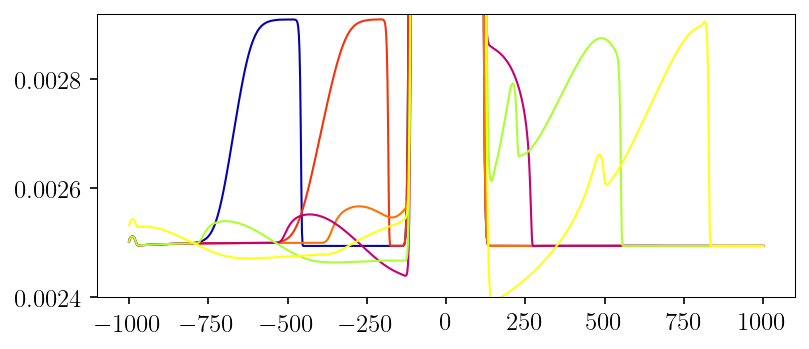

In [167]:
fig, ax = plt.subplots(1,1, figsize=(6,2.5))

# density sections
axis = ax
#axis.set_ylim(0.098,0.10965)
axis.set_ylim(0.0024,0.00292)
for i in range(len(frames)):
    frame = frames[i]
    axis.plot(X, (frame.prs[:,SECTION]), color=color[i])
    # find the front of the wave
    large = (frame.rho[:,0]/ref.rho[:,0])>1.05 # the large excitations
    indexes = np.where(large == 1)
    index = indexes[0][-1]
    print(index)
    physical_position = X_EXTENT[0] + (X_EXTENT[1]-X_EXTENT[0])*index/X_POINTS
    print(physical_position)
    #axis.plot([physical_position, physical_position], [-10,10], '--', color=color[i])

Reading Data file : data/plume-raw-G3/data.0160.dbl


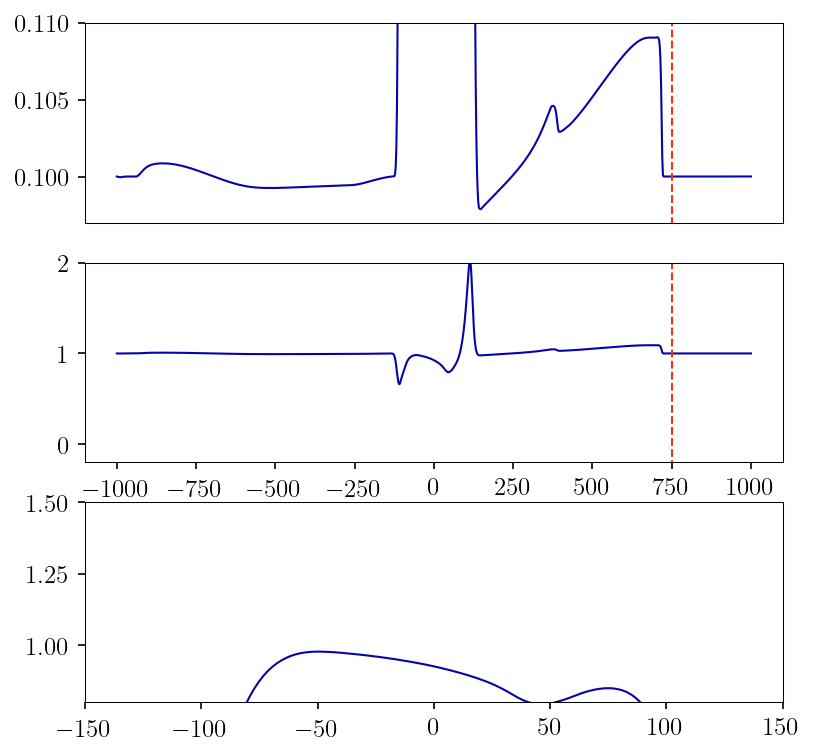

In [157]:
#n = 127
n = 160
X = np.linspace(X_EXTENT[0], X_EXTENT[1], X_POINTS)

D = pp.pload(n, w_dir=DATA_DIR)

fig, ax = plt.subplots(3,1, figsize=(6,6))

# find the front of the wave
large = (D.rho[:,0]/ref.rho[:,0])>1.05 # the large excitations
indexes = np.where(large == 1)
index = indexes[0][-1]
physical_position = X_EXTENT[0] + (X_EXTENT[1]-X_EXTENT[0])*index/X_POINTS

# outside
axis = ax[0]
axis.set_ylim(0.097,0.11)
axis.plot(X, D.rho[:,SECTION])
axis.plot([physical_position, physical_position], [-10,10], '--')
axis.get_xaxis().set_visible(False)

# relative
axis = ax[1]
axis.plot(X, D.rho[:,SECTION]/ref.rho[:,SECTION])
axis.plot([physical_position, physical_position], [-10,10], '--')
axis.set_ylim(-0.2,2)

# inside
axis = ax[2]
axis.plot(X, D.rho[:,SECTION])
axis.plot([physical_position, physical_position], [-10,10], '--')
axis.set_ylim(0.8,1.5)
axis.set_xlim(-150,150)

plt.show()

In [108]:
for n in range(2,5):
    D = pp.pload(n, w_dir=DATA_DIR)

    fig, ax = plt.subplots(3,1, figsize=(6,6))

    # find the front of the wave
    large = (D.rho[:,0]/ref.rho[:,0])>1.05 # the large excitations
    indexes = np.where(large == 1)
    index = indexes[0][-1]
    physical_position = X_EXTENT[0] + (X_EXTENT[1]-X_EXTENT[0])*index/X_POINTS

    # outside
    axis = ax[0]
    axis.set_ylim(0.097,0.11)
    axis.plot(X, D.rho[:,SECTION])
    axis.plot([physical_position, physical_position], [-10,10], '--')
    axis.get_xaxis().set_visible(False)

    # relative
    axis = ax[1]
    axis.plot(X, D.rho[:,SECTION]/ref.rho[:,SECTION])
    axis.plot([physical_position, physical_position], [-10,10], '--')
    axis.set_ylim(-0.2,2)

    # inside
    axis = ax[2]
    axis.plot(X, D.rho[:,SECTION])
    axis.plot([physical_position, physical_position], [-10,10], '--')
    axis.set_ylim(0.75,1.35)
    axis.set_xlim(-150,150)
    
    fig.savefig("data/images/wave-front/image%03i.png"%n)
    plt.close(fig=fig)

Reading Data file : data/plume-raw-G3-smol/data.0002.dbl
Reading Data file : data/plume-raw-G3-smol/data.0003.dbl
Reading Data file : data/plume-raw-G3-smol/data.0004.dbl
